# <center> Hansen(1985, JME), Real Business Cycle Model </center>
## Motivation
- How to account for the existence of unemployment
- How to account for the fluctuations in the unemployment rate
- Fluctuations in housrs worked are larger that productivity
## What the paper does
- a simple one-sector stochastic growth model
- shocks to technology
- Indivisible labor:either work given positive number of hours or not at all(consistent with the facts)
## What the paper finds
- fluctuation in aggregate hours is due to flouctuation in the number of employed
- amount of variability in hours worked is 2.7 times of that of productivity(1.4 in data) 

$$
\max_{c_t,l_t,k_{t+1}} E_0 \sum_{t=0}^{\infty}\beta^t u(c_t,1-l_t), \\
c_t+i_t \le \theta_t k_t^\alpha l_t^{1-\alpha}, \\
k_{t+1}=i_t + (1-\delta)k_t, \\
k_0, \theta_0 \text{ given}, c_t,k_t,l_t \ge 0, l_t \ge 0, l_t \in (0,1) \text{ for all } t.
$$

The utility function is assumed to be of the form:

$$
u(c_t, 1-l_t)=\frac{(c_t^a(1-l_t)^{1-a})^{1-\sigma}}{1-\sigma}, \sigma > 0 \text{ and } \sigma \neq 1.
$$

Controls: $c_t, l_t, i_t$ and $k_{t+1}$ and states: $k_t$ and $\theta_t$,

$$
V(k,\theta)=\max_{k',l}\{\log(\theta k^\alpha l^{1-\alpha}-k'+(1-\delta)k)+\beta EV(k',\theta') \} \\
k_0, \theta_0 \text{ given}, k_t \ge 0, l_t \in (0,1) \text{ for all } t.
$$

We need to solve for:

$$
k'=g_k(k,\theta), \\
l = g_l(k,\theta), \\
g_c(k,\theta) = \theta k^\alpha g_l(k,\theta)^{1-\alpha}+(1-\delta)k-g_k(k,\theta)
$$

In [1]:
# divisible labor
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
# import statsmodels.api as sm


# Tauchen approximation
def approx_markov(rho, sigma, m=3, n=7):
    # districize state space
    stdy = np.sqrt(sigma**2/(1-rho**2))
    ymax = m*stdy
    ymin = -ymax
    ygrid = np.linspace(ymin,ymax,n)   # state space
    s = (ymax-ymin)/(n-1)  # distance between two grids
    
    np.set_printoptions(precision=4,suppress=True)  # set output format
    # transition matrix
    Trans = np.zeros((n,n))
    for i in range(n):
        Trans[i][0] = norm.cdf(ygrid[0]-rho*ygrid[i]+s/2,0,sigma)
        Trans[i][n-1] = 1-norm.cdf(ygrid[n-1]-rho*ygrid[i]-s/2,0,sigma)
        for j in range(n-2):
            Trans[i][j+1] = norm.cdf(ygrid[j+1]-rho*ygrid[i]+s/2,0,sigma)\
            - norm.cdf(ygrid[j+1]-rho*ygrid[i]-s/2,0,sigma)
            
    # stationary distribution
    Transt = np.transpose(Trans)
    p = np.ones((n,1))/n
    test = 1
    while test>1e-6:
        p1 = np.matmul(Transt,p)
        test = max(abs(p1-p))
        p = p1
    
    return Trans,p,ygrid

## Step 1: Parameters and Steady State

To calculate the steady state, we can fix the level of hours worked $l_{ss} = 0.33$ and solve for the parameter $a$ that satisfies the equilibrium equations, where $U = a\log(c)+(1-a)\log (1-l)$. The equations determining the equilibrium of the model are given by:
$$
u_c'(c,1-l)=\beta E[u_c'(c',1-l')(\alpha \theta'k'^(\alpha-1)l'^{1-\alpha}+1-\delta)],\\
c+i=\theta k^\alpha l^{1-\alpha},\\
i = k'-(1-\delta)k,\\
u_c'(c,1-l)[(1-\alpha)\theta k^\alpha l^{-\alpha}]=u_l'(c,1-l).
$$

Further, imposing $\theta_{ss}=E\theta'=E\theta$ and $x=x'$ for all variables, we get:

$$
k_*=(\frac{1-\beta(1-\delta)}{\beta \alpha \theta_{ss}})^{\frac{1}{\alpha-1}},\\
k_{ss}=k_* l_{ss},\\
i_{ss}=\delta k_{ss},\\
c_{ss}=\theta_{ss}k_{ss}^\alpha l_{ss}^{1-\alpha}-i_{ss},\\
y_{ss}=\theta k_{ss}^\alpha l_{ss}^{1-\alpha},\\
a = \frac{c_{ss}}{(1-\alpha)\theta_{ss}k_*^\alpha(1-l_{ss})+c_{ss}}
$$


In [2]:
# setting parameters
a=2;
beta=0.99;
alpha=0.36;
delta=0.025;
rho=0.95;
m=3;
sigma=0.00712;
kstates=50;
n=7;
tolv=1e-6

# generate markov chain
p = approx_markov(rho, sigma, m, n)[1]   #7*1
Trans = approx_markov(rho, sigma, m, n)[0]
z =  approx_markov(rho, sigma, m, n)[2] # 7-state array
z = z+1
z = np.reshape(z,(1,7))
Ez = np.matmul(z,p)[0][0]

# calculate steady states
kls=((1/beta-(1-delta))/(alpha*Ez))**(1/(alpha-1)) # capital labor ratio
lss=Ez*(1-alpha)/(a+1-alpha-a*delta*kls**(1-alpha))
kss = kls*lss
yss = Ez*kss**alpha*lss**(1-alpha)
iss = delta*kss
css = yss - iss

An Alternative Utility Function

$$
u(c_t,1-l_t)=\frac{c_t^{1+\gamma_c}}{1+\gamma_c}+\frac{(1-l_t)^{1+\gamma_l}}{1+\gamma_l}
$$

Here, we fix the parameter $\gamma_l$ and use a non-linear equation to solve for $l_{ss}$. The equation system used to solve for the steady state values of capital, labor and consumption is given below:

$$
1 = \beta(\alpha \theta_{ss}k_{ss}^{\alpha-1}l_{ss}^{1-\alpha}+1-\delta),\\
(1-l_{ss})^{\gamma_l}=c_{ss}^{\gamma_c}(1-\alpha)\theta_{ss}k_{ss}^\alpha l_{ss}^{-\alpha},\\
c_{ss}=\theta_{ss}k_{ss}^\alpha l_{ss}^{1-\alpha}-\delta k_{ss}
$$

## Step 2: Creation of the grids
Create a grid vector for $k$ with $l_k$ values, i.e. $k \in [k_1 < k_2 < \dots < k_{l_k}]$, and, if we discretize labor, a grid with $l_l$ values for $l$, i.e. $l \in [l_1 < l_2 < ... < l_l]$. With $l_k=2$ and $l_l=2$, the grids are given by:
$$
k = 16.3658,17.7296 \\
l = 0.2865,0.3135
$$


In [3]:
# capital grid
kgrid = np.linspace(0.95*kss,1.05*kss,kstates)
utility = lambda con,lab:np.log(con)+a*np.log(1-lab)
print(kgrid)

[10.8582 10.8815 10.9048 10.9282 10.9515 10.9748 10.9981 11.0215 11.0448
 11.0681 11.0914 11.1148 11.1381 11.1614 11.1847 11.2081 11.2314 11.2547
 11.278  11.3014 11.3247 11.348  11.3714 11.3947 11.418  11.4413 11.4647
 11.488  11.5113 11.5346 11.558  11.5813 11.6046 11.6279 11.6513 11.6746
 11.6979 11.7212 11.7446 11.7679 11.7912 11.8145 11.8379 11.8612 11.8845
 11.9078 11.9312 11.9545 11.9778 12.0012]


## Step 3: Computation of the return function

For each value of $\theta, k, l \text{ and } k'$, calculate the consumption and return functions from:

$$
c = \theta k^\alpha l^{1-\alpha}-k',\\
U(c,1-l)=\frac{(c^a(1-l)^{1-a})^{1-\sigma}}{1-\sigma} \text{ or }\frac{c_t^{1+\gamma_c}}{1+\gamma_c}+\frac{(1-l_t)^{1+\gamma_l}}{1+\gamma_l} 
$$

If $\theta=\theta_t, k = k_i \text{ and } k'=k_j'$, the following vector is created: 

$$
u = [U(c_{ij}(\theta_t,l_1),1-l_1) U(c_{ij}(\theta_t,l_2),1-l_2) \dots U(c_{ij}(\theta_t,l_l),1-l_l)],\\
c_{ij}(\theta_t,l_h)=\theta_t k_i^\alpha l_h^{1-\alpha} + (1-\delta)k_i - k_j
$$

The vector is then maximized with respect to $l$, and a return matrix of dimensions $g_k \times l_\theta$ , where $g_k = l_k \times l_k$ is the number of all possible combinations of $k$ and $k'$ , and $l_\theta$ is the number of possible values of the shock, is created with the maximized utilities. 

In [4]:
# solving optimal labor and return for all k, k'
focl = lambda h,z,k,kpr:((1-h)*(1-alpha)*z*k**alpha*h**(-alpha)-\
                         a*(z*k**alpha*h**(1-alpha)+(1-delta)*k-kpr))
zstates = n
U = np.zeros((kstates*kstates,zstates))
optiml = np.zeros((kstates*kstates,zstates))  # storing optimal l for all k,k'
for s in range(zstates):
    for i in range(kstates):
        for j in range(kstates):
            lab = fsolve(lambda h:focl(h,z[0][s],kgrid[i],kgrid[j]), [0.2])
            if lab<0:
                lab = 0
            if lab>1:
                lab=1
            optiml[i*kstates+j][s] = lab
            con = z[0][s]*kgrid[i]**alpha*lab**(1-alpha)+(1-delta)*kgrid[i]-kgrid[j]
            if con<0:
                con = 1e-6
            U[i*kstates+j][s] = utility(con,lab)

## Step 4: Computation of the optimal value function

In [5]:
# Initialize of the value function
v0 = np.ones((kstates,zstates))
v1 = np.zeros((kstates,zstates))

while abs(np.linalg.norm(v1 - v0)) > tolv:
    v0 = np.copy(v1)
    for s in range(zstates):
        for i in range(kstates):
            u = np.reshape(U[:,s][i*kstates:(i+1)*kstates],(kstates,1))
            v1[i][s] = np.max(u+beta*np.matmul(v0,np.reshape(Trans[1,:],(n,1))))  
print(v0)

[[-97.1719 -97.1391 -97.1069 -97.0742 -97.0411 -97.0075 -96.9736]
 [-97.1409 -97.1088 -97.0767 -97.044  -97.0109 -96.9774 -96.9435]
 [-97.1104 -97.0787 -97.0465 -97.0139 -96.9808 -96.9473 -96.9134]
 [-97.0801 -97.0486 -97.0164 -96.9838 -96.9508 -96.9173 -96.8834]
 [-97.05   -97.0185 -96.9863 -96.9537 -96.9207 -96.8873 -96.8535]
 [-97.02   -96.9884 -96.9563 -96.9237 -96.8907 -96.8573 -96.8235]
 [-96.9899 -96.9583 -96.9263 -96.8937 -96.8608 -96.8274 -96.7936]
 [-96.9599 -96.9283 -96.8963 -96.8638 -96.8309 -96.7976 -96.7638]
 [-96.9299 -96.8984 -96.8664 -96.8339 -96.801  -96.7677 -96.734 ]
 [-96.9    -96.8685 -96.8365 -96.804  -96.7712 -96.7379 -96.7042]
 [-96.8701 -96.8386 -96.8066 -96.7742 -96.7414 -96.7081 -96.6745]
 [-96.8402 -96.8087 -96.7768 -96.7445 -96.7117 -96.6784 -96.6448]
 [-96.8103 -96.7789 -96.747  -96.7147 -96.682  -96.6488 -96.6152]
 [-96.7805 -96.7492 -96.7173 -96.685  -96.6523 -96.6191 -96.5856]
 [-96.7508 -96.7194 -96.6876 -96.6554 -96.6227 -96.5896 -96.5561]
 [-96.7211

## Step 5: Computation of the optimal policy functions

For each point in the grid, we find the index of the capital maximizer and extract the corresponding optimal labor.

In [6]:
# optimal policy function
optimindk = np.zeros((kstates,zstates))
polk = np.zeros((kstates,zstates))
poll = np.zeros((kstates,zstates))
for s in range(zstates):
    for i in range(kstates):
        u = np.reshape(U[:,s][i*kstates:(i+1)*kstates],(kstates,1))
        optimindk[i][s] = np.argmax(u+beta*np.matmul(v0,np.reshape(Trans[1,:],(n,1))))
optimindk = optimindk.astype(int)

For any value of the shock, the optimal next period capital is always equal to the initial one. Using these matrices, the policy functions can be calculated as follows:
$$
\begin{aligned}
& \text { polk }=\left[\begin{array}{ll}
g_k\left(k_1, \theta_1\right) \cdots & g_k\left(k_1, \theta_7\right) \\
g_k\left(k_2, \theta_1\right) \cdots & g_k\left(k_2, \theta_7\right)
\end{array}\right] \\
& \text { polc }=\max _l\left[\begin{array}{cc}
\theta_1 k_1^\alpha l^{1-\alpha} \cdots & \theta_7 k_1^\alpha l^{1-\alpha} \\
\theta_1 k_2^\alpha l^{1-\alpha} \cdots & \theta_7 k_2^\alpha l^{1-\alpha}
\end{array}\right]+(1-\delta)\left[\begin{array}{ll}
k_1 \cdots & k_1 \\
k_2 \cdots & k_2
\end{array}\right]-\text { polk } \\
&
\end{aligned}
$$

In [7]:
for s in range(zstates):
    for i in range(kstates):
        poll[i][s] = optiml[i*kstates+optimindk[i][s]][s]
        polk[i][s] = kgrid[optimindk[i][s]]

poli = -(1-delta)* np.matmul(np.reshape(kgrid,(kstates,1)),np.ones((1,n)))+polk;
polc = np.multiply(np.matmul(np.ones((kstates,1)),z),\
                   np.multiply(np.power(polk,alpha),np.power(poll,1-alpha)))-poli;

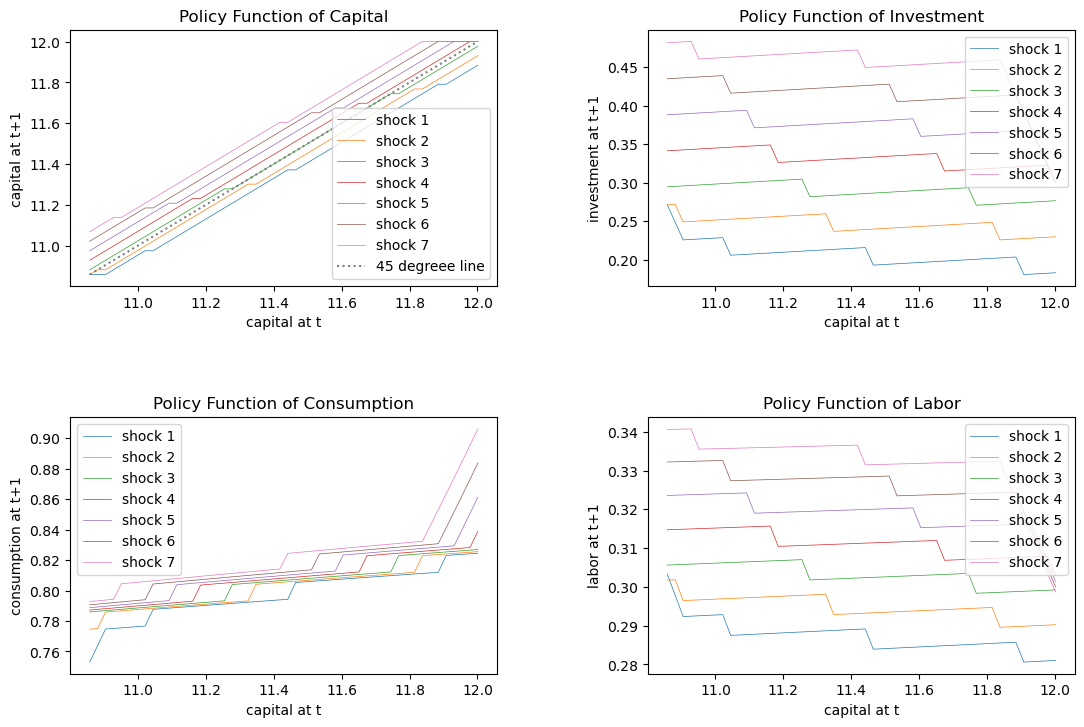

In [8]:
# plot policy function
fig, ax = plt.subplots(2,2)
for i in range(n):
    ax[0,0].plot(kgrid, polk[:,i],label='shock {}'.format(i+1),linewidth=0.5)
ax[0,0].plot(kgrid, kgrid,label='45 degreee line',linestyle='dotted')
ax[0,0].set(xlabel='capital at t', ylabel='capital at t+1')
ax[0,0].set_title("Policy Function of Capital")
ax[0,0].legend()

for i in range(n):
    ax[0,1].plot(kgrid, poli[:,i],label='shock {}'.format(i+1),linewidth=0.5)
ax[0,1].set(xlabel='capital at t', ylabel='investment at t+1')
ax[0,1].set_title("Policy Function of Investment")
ax[0,1].legend()

for i in range(n):
    ax[1,0].plot(kgrid, polc[:,i],label='shock {}'.format(i+1),linewidth=0.5)
ax[1,0].set(xlabel='capital at t', ylabel='consumption at t+1')
ax[1,0].set_title("Policy Function of Consumption")
ax[1,0].legend()

for i in range(n):
    ax[1,1].plot(kgrid, poll[:,i],label='shock {}'.format(i+1),linewidth=0.5)
ax[1,1].set(xlabel='capital at t', ylabel='labor at t+1')
ax[1,1].set_title("Policy Function of Labor")
ax[1,1].legend()

fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(12)

## Simulating the model

Choose an initial value for $k_0$ and $\theta_0$ and use the policy matrix to extract the optimal …rst period capital.

We then create a loop that:
- Given the initial capital and the initial shock, finds the position of the optimal next period capital.
- Uses the initial capital, the initial shock index, and the position of the new optimal capital to calculate the values of output, consumption, labor and the next period capital, using the optimal policy matrices. It also generates a new shock index for next period.

In [9]:
# simulae Markov chain
def mc_simulation(P, inital_state=None, sample_size=1_000):

    X = np.empty(sample_size, dtype=int)
    # Convert each row of P into a cdf
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]

    # draw initial state, defaulting to 0
    if inital_state is not None:
        X_0 = qe.random.draw(np.cumsum(inital_state))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])
        
    return X

# simulation
T = int(input('Please enter the periods you want to simulate: '))
N = int(input('Please enter the number of simulations you want to do: '))

cycle = np.zeros((N,6))
trend = np.zeros((N,6))  
std = np.zeros((N,6))  # storing standard deviation of y,c,i,k,l,z in each simulation
corr = np.zeros((N,6))  # storing coefficient of correnlation of y,c,i,k,l,z between y
for i in range(N):
    sim = np.zeros((T,6))   # storing simulated value of y,c,i,k,l,z each time
    ksim = np.zeros(T+1)
    indk = 10     # dicitate initial value of capital
    ksim[0] = indk
    shock = mc_simulation(Trans, inital_state=None, sample_size=T)
    for t in range(T):
        s = shock[t]
        sim[t][3] = ksim[t]   # capital
        sim[t][5] = z[0][s] # shock
        sim[t][4] = poll[indk][s]   # labor
        ksim[t+1] = polk[indk][s]
        sim[t][0] = z[0][s]*ksim[t]**alpha*sim[t][4]**(1-alpha)  #output
        sim[t][2] = poli[indk][s]   # investment
        sim[t][1] = polc[indk][s]   # consumption
        indk = optimindk[indk][s]   # capital evolves via its policy function
    sim = np.log(sim)
    # hp filter 
    for j in range(6):
        cycle[:,j],trend[:,j] = sm.tsa.filters.hpfilter(sim[:,j], 1600)

    for j in range(6):
        std[i][j] = np.std(cycle[:,j])
        corr[i][j] = np.corrcoef(cycle[:,j],cycle[:,0])[0][1]
        
std_avg = np.mean(std,axis=0)   # standard deviation of y,c,i,k,l
corr_avg = np.mean(corr,axis=0)   # coefficient of correlation between y and other variables
print('\n')
print("Standard deviation in percent of output, consumption, investment, capital, labor and TFP shock are: ")
print(std_avg*100)
print('\n')
print("Coefficient of correlation of output between output, consumption, investment, capital, labor and TFP shock are: ")
print(corr_avg)

Please enter the periods you want to simulate: 30
Please enter the number of simulations you want to do: 50


NameError: name 'sm' is not defined